In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from numpy import arange, quantile
from numpy.random import randint, permutation

# Scalar Quantiles via Optimal Transport

In [2]:
# Data
np.random.seed(42)

T = 100
N = 1000
Y = np.random.randn(N)[:, None]  # permutation(arange(start=0.0, stop=10.0, step=10/N))

U = 1 / T * (np.arange(0, T) + 1)

In [3]:
D = np.zeros([T, T])
D[1:, :] = -np.eye(T - 1, T)
D[:, :] += np.eye(T)
Dinv = np.linalg.inv(D)

one_N = np.ones([N, 1])
one_T = np.ones([T, 1])
Pi_cp = cp.Variable(shape=(T, N))

In [4]:
# Problem definition
objective = U.T @ Pi_cp @ Y
constraints = [
    Pi_cp @ one_N == 1 / T * one_T,
    Pi_cp >= 0,
    one_T.T @ Pi_cp == 1 / N * one_N.T,
]

problem = cp.Problem(objective=cp.Maximize(objective), constraints=constraints)
problem.solve(verbose=True,)
quantiles = D @ constraints[0].dual_value * T  # Figure out why scaling is required
gt = quantile(Y.squeeze(), q=U.squeeze())

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 24 12:59:11 PM: Your problem has 100000 variables, 3 constraints, and 0 parameters.
(CVXPY) Jul 24 12:59:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 24 12:59:11 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 24 12:59:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 24 12:59:11 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 24 12:59:11 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

Text(0.5, 1.0, 'Pi')

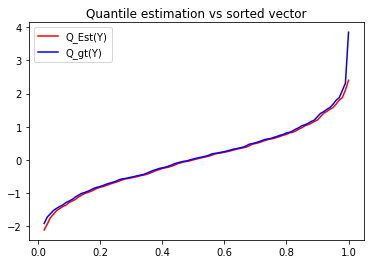

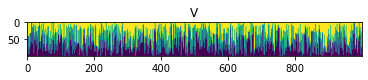

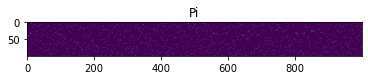

In [5]:
plt.figure()
plt.plot(U[1:], quantiles.squeeze()[1:], "r")
plt.plot(U[1:], gt[1:], "b")
plt.title("Quantile estimation vs sorted vector")
plt.legend(["Q_Est(Y)", "Q_gt(Y)"])

V = Dinv.T @ Pi_cp.value

plt.figure()
plt.imshow(V)
plt.title("V")
# plt.colorbar()


plt.figure()
plt.imshow(Pi_cp.value)
plt.title("Pi")
# plt.colorbar()

# Vector Quantiles

In [6]:
# Data
np.random.seed(42)

d = 2
T = 25
N = 500
# Y = np.random.randn(N, d)
rho = 0.9
Y = np.random.multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]], size=(N,))

u = 1 / T * (np.arange(0, T) + 1)
U1, U2 = np.meshgrid(*([u,]*d)) # not handling d>2
U = np.stack([U1.reshape(-1), U2.reshape(-1)], axis=1)

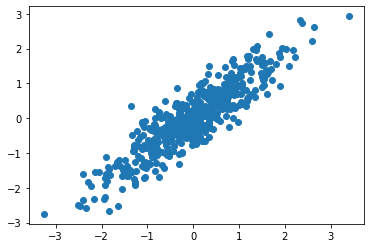

In [7]:
plt.scatter(Y[:, 0], Y[:, 1])

In [8]:
from scipy.spatial.distance import cdist

# Pairwise distances (similarity)
S = cdist(U, Y, lambda x, y: x.dot(y))  # original: why only inner product?
# S = cdist(U, Y, 'cosine')
S.shape

(625, 500)

In [9]:
Td = T ** d

one_N = np.ones([N, 1])
one_T = np.ones([Td, 1])
Pi_cp = cp.Variable(shape=(Td, N))

In [10]:
# Problem definition

objective = cp.sum(cp.multiply(Pi_cp, S))

constraints = [
    Pi_cp @ one_N == 1 / Td * one_T,
    Pi_cp >= 0,
    one_T.T @ Pi_cp == 1 / N * one_N.T,
]

problem = cp.Problem(objective=cp.Maximize(objective), constraints=constraints)
problem.solve(verbose=True,)
gt = quantile(Y.squeeze(), q=U.squeeze())

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jul 24 12:59:14 PM: Your problem has 312500 variables, 3 constraints, and 0 parameters.
(CVXPY) Jul 24 12:59:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 24 12:59:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 24 12:59:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 24 12:59:14 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 24 12:59:14 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

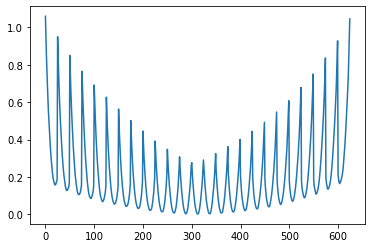

In [11]:
B = constraints[0].dual_value
plt.plot(constraints[0].dual_value)

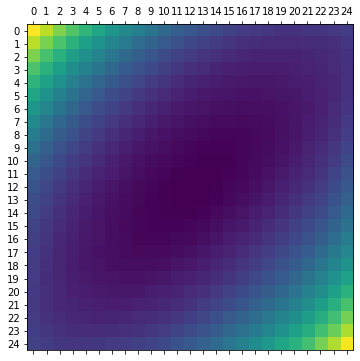

In [12]:
B = B.reshape(T, T)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.matshow(B); ax.set_xticks(range(T)); ax.set_yticks(range(T));

(25, 25) (25, 25)


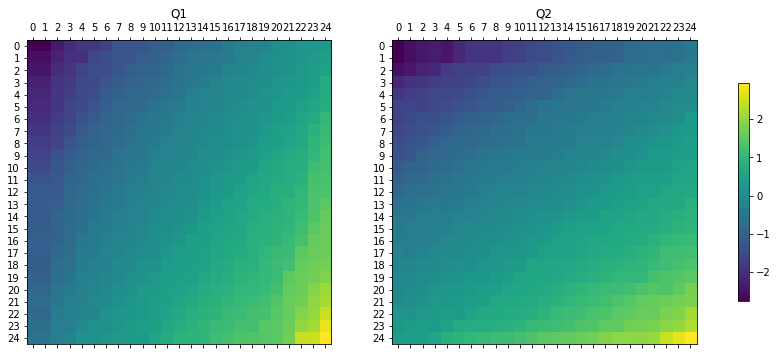

In [13]:
# Extract quantile surfaces
dB_du1 = (B[:, 1:] - B[:, :-1])/(1/T)
dB_du2 = (B[1:, :] - B[:-1, :])/(1/T)

# Duplicate first row/col and insert it BEFORE
dB_du1 = np.pad(dB_du1, [(0, 0), (1, 0)], mode="edge")
dB_du2 = np.pad(dB_du2, [(1, 0), (0, 0)], mode="edge")

Q1, Q2 = dB_du1, dB_du2

print(Q1.shape, Q2.shape)

fig, axes = plt.subplots(1, 2, figsize=(15, 20))
for i, (ax, Q) in enumerate(zip(axes, [Q1, Q2]), start=1):
    m = ax.matshow(Q)
    ax.set_xticks(range(T))
    ax.set_yticks(range(T))
    ax.set_title(f"Q{i}")
    
fig.colorbar(m, ax=axes, shrink=0.2)

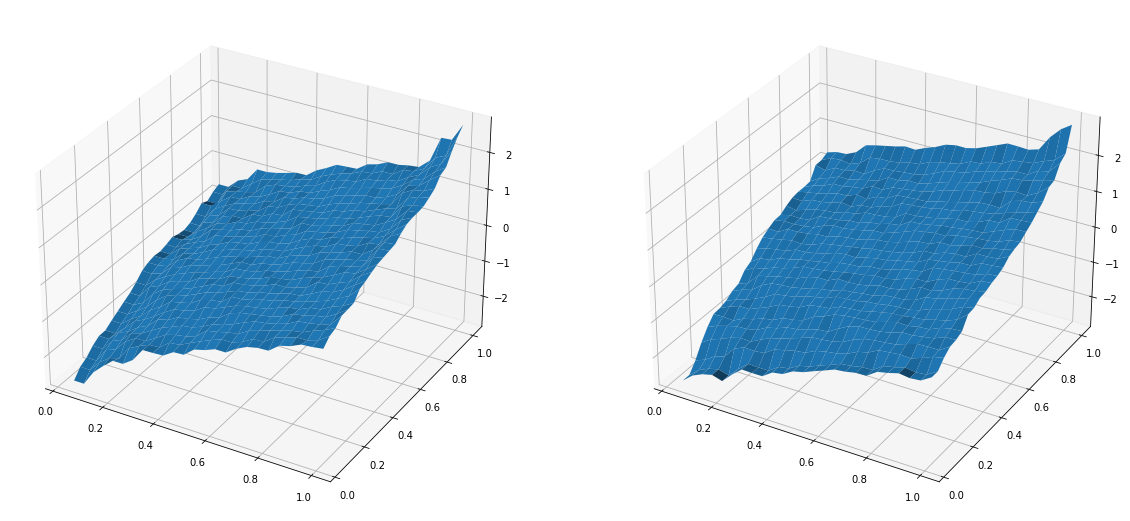

In [14]:
fig, ax = plt.subplots(1, d, figsize=(20, 10), subplot_kw={"projection": "3d"})

ax[0].plot_surface(U1, U2, Q1)
ax[1].plot_surface(U1, U2, Q2)


### Validate monotonicity

In [15]:
import itertools as it

ii = jj = tuple(range(1, T))

n, n_c = 0, 0
offending_points = []
offending_dists = []
for i0, j0 in it.product(ii, jj):
    
    u0 = np.array([U1[i0, j0], U2[i0, j0]])
    q0 = np.array([Q1[i0, j0], Q2[i0, j0]])
    
    for i1, j1 in it.product(ii, jj):
        n+=1

        u1 = np.array([U1[i1, j1], U2[i1, j1]])
        q1 = np.array([Q1[i1, j1], Q2[i1, j1]])
        
        if np.dot(q1-q0, u1-u0) < 0:
            offending = (
                f"{(i0, j0)=}, {(i1, j1)=}, "
                f"{q1-q0=}, "
                f"{u1-u0=}, "
                f"{np.dot(q1-q0, u1-u0)=}"
            )
            offending_points.append(offending)
            offending_dists.append(np.dot(q1-q0, u1-u0).item())
            n_c +=1
            

print(f"{n=}, {n_c=}, {n_c/n=:.2f}")
assert len(offending_points)==0

n=331776, n_c=0, n_c/n=0.00


In [16]:
# plt.hist(offending_dists, 50)

### Comparison of quantile decode

In [17]:
EPS=0.0001

# Crazy Russian method :(

def b_to_quantile(f, T, U1, U2, step):
    fact=10/step
    l=T.shape[0]
    m=U1.shape[0]
    print(f"{f.shape=}, {fact=:.2f}, {l=}, {m=}, {step=:.2f}")
    
    D1=np.zeros(m)
    D2=np.zeros(m)
    
    for i1 in range(1, l):
        u1=T[i1]
        
        for i2 in range(1, l):
            u2=T[i2]
            
            j=np.where((fact*U1 + U2)==(fact*u1+u2))
            
            jprecx=np.where(abs((fact*U1 + U2)-(fact*(u1-step)+u2))<EPS)
            
            jprecy=np.where(abs((fact*U1 + U2)-(fact*u1+(u2-step)))<EPS)
            
            D1[j]=(f[j]-f[jprecx])/step
            D2[j]=(f[j]-f[jprecy])/step
            
    return D1, D2

f.shape=(625, 1), fact=250.00, l=25, m=625, step=0.04


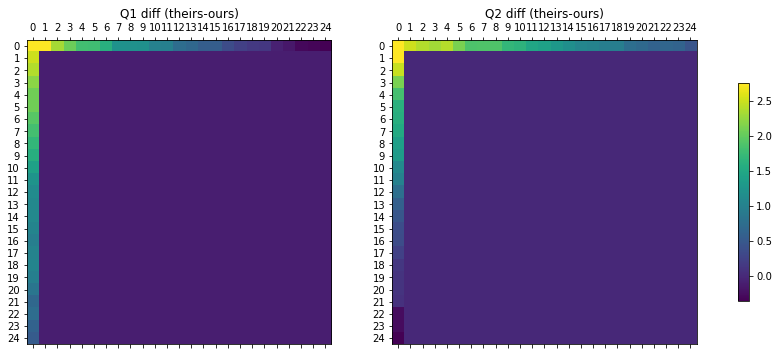

In [18]:
Q1_, Q2_ = b_to_quantile(constraints[0].dual_value, u, U1.reshape(-1), U2.reshape(-1), 1/T)
Q1_ = Q1_.reshape([T, T])
Q2_ = Q2_.reshape([T, T])

fig, axes = plt.subplots(1, 2, figsize=(15, 20))
for i, (Q, Q_) in enumerate(zip([Q1, Q2], [Q1_, Q2_])):
    m= axes[i].matshow(Q_-Q)
    axes[i].set_xticks(range(T))
    axes[i].set_yticks(range(T))
    axes[i].set_title(f"Q{i+1} diff (theirs-ours)")
    
fig.colorbar(m, ax=axes, shrink=0.2);

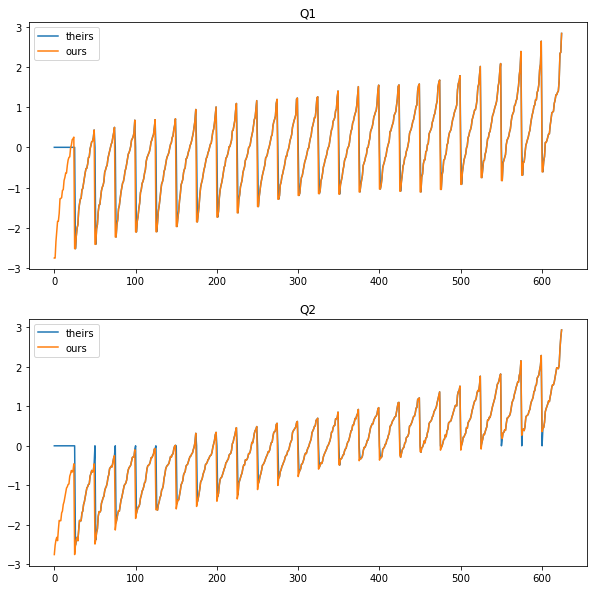

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for i, (Q, Q_) in enumerate(zip([Q1, Q2], [Q1_, Q2_])):
    ax[i].plot(Q_.reshape(-1), label="theirs")
    ax[i].plot(Q.reshape(-1), label="ours")
    ax[i].set_title(f"Q{i+1}")
    ax[i].legend()

In [20]:
for i, (Q, Q_) in enumerate(zip([Q1, Q2], [Q1_, Q2_])):
    diff = Q_[1:, 1:] - Q[1:, 1:]
    assert np.allclose(diff, 0.0)